# 228Th and 208Tl preprod to 

* Check the efficiency of 208Tl simulation
* Check if we need to simulate all the 228Th chain or not

In [1]:
import pandas as pd
import tables as tb
import glob
import numpy as np
from invisible_cities.io.dst_io import load_dst

In [2]:
path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calibration/toy_{isotope}/prod/{port}/nexus/*.h5'

In [3]:
# NUMBER OF SIMULATED EVENTS
nevent_per_file = 2000
nfiles_per_port = 25
nevents_per_port = nevent_per_file * nfiles_per_port
nport = 4
nevents = nevents_per_port * nport

## 208Tl

In [4]:
def get_mc_info(f):
    hit_df = load_dst(f, 'MC', 'hits')
    conf_df = load_dst(f, 'MC', 'configuration')
    hit_df = hit_df.merge(hit_df.groupby('event_id').energy.sum().rename('tot_ene'), on='event_id')
    hit_df = hit_df.merge(hit_df.groupby('event_id').size().rename('nhits'), on='event_id')
    hit_df_ = hit_df[['event_id', 'tot_ene', 'nhits']].drop_duplicates()

    hit_df_['port'] = conf_df[conf_df.param_key == '/Generator/IonGenerator/region'].param_value.values[0].replace(' ', '')
    return hit_df_

In [5]:
# info_df_208Tl = pd.DataFrame()
# for f in sorted(glob.glob(path.format(isotope='208Tl', port='*')), key = lambda x: (x.split('/')[-3], int(x.split('_')[-2]))):
#     info_df_208Tl = info_df_208Tl.append(get_mc_info(f))

In [6]:
sim_evs_info = pd.DataFrame([{'sim_evs_per_file': 2000, 'sim_files_per_port': 25, 'n_ports':4}])

In [7]:
save_path_208Tl = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calibration/toy_208Tl/toy_summary_208Tl.h4'
# info_df_208Tl.to_hdf(save_path_208Tl, key = 'events_info') 
# sim_evs_info.to_hdf(save_path_208Tl, key = 'sim_info') 

In [8]:
info_df_208Tl = pd.read_hdf(save_path_208Tl, 'events_info')
sim_evs_info = pd.read_hdf(save_path_208Tl, 'sim_info')

In [71]:

size_path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calibration/size_data.txt'
with open(size_path, 'r') as f:
        text = f.readlines()
        f.close()
folder_size = [[t.split("\t")[1].split('/')[0].split('_')[1], t.split("\t")[1].split('/')[2].rstrip('\n'),float(t.split("\t")[0].rstrip('G').replace(',', '.'))] for t in text[:-1]]
size_df = pd.DataFrame(folder_size, columns = ['isotope', 'port', 'size'])

In [86]:
info_df_208Tl[(info_df_208Tl.tot_ene > 0.4)].groupby('port').size()

port
PORT_1a    4826
PORT_1b    4590
PORT_2a    3793
PORT_2b    4787
dtype: int64

port
PORT_1a    1.6
PORT_1b    1.6
PORT_2a    1.6
PORT_2b    1.6
Name: size, dtype: float64

In [97]:
size_df[size_df.isotope == '208Tl'].drop(columns='isotope').set_index('port')['size'] / info_df_208Tl[(info_df_208Tl.tot_ene > 0.4)].groupby('port').size() * 1e6

port
PORT_1a    331.537505
PORT_1b    348.583878
PORT_2a    421.829686
PORT_2b    334.238563
dtype: float64

In [ ]:
df.groupby('port').size()

In [83]:
(size_df[size_df.isotope == '208Tl']['size'] /nevents_per_port) * 13200000 

0    422.4
1    422.4
2    422.4
3    422.4
4    554.4
5    554.4
6    501.6
7    554.4
Name: size, dtype: float64

In [84]:
size_df

,isotope,port,size
0,208Tl,PORT_1a,1.6
1,208Tl,PORT_1b,1.6
2,208Tl,PORT_2a,1.6
3,208Tl,PORT_2b,1.6
4,228Th,PORT_1a,2.1
5,228Th,PORT_1b,2.1
6,228Th,PORT_2a,1.9
7,228Th,PORT_2b,2.1


In [113]:
def print_effs_and_sim(df, isotope, size_df, e_threshold = (0, np.inf), nevents_per_port = 5e4, nevents = 2e5, desired_events = 1e6, round_factor = 1e5, target_evs_file = 2e4):
    df = df[(df.tot_ene > e_threshold[0]) & (df.tot_ene < e_threshold[1])]
    size_df = size_df[size_df.isotope == isotope].drop(columns='isotope').set_index('port')['size']
    port_eff = df.groupby('port').size() / nevents_per_port

    print('MC efficiencies ({} < E < {})'.format(e_threshold[0], e_threshold[1]))
    print('Each port:')
    print(port_eff)
    print('')

    print('Total efficiency')
    print(len(df) / nevents)

    print('')
    print('In each port we will need to simulate (to have at least 1M events):')
    print(desired_events / port_eff)

    print('')
    print('Which we can set up to:')
    target_evs_port = np.ceil((desired_events / port_eff).max() / round_factor) * round_factor
    print(target_evs_port, ' events per port')
    print(target_evs_port / target_evs_file, ' tasks/files per port if we simulate ', target_evs_file, ' events per file')
    print('With the current eff, these files will have around ', target_evs_file * port_eff.mean(), ' events per file')
    print('')
    print('For having 1M, we expect that the production will occupy:')
    expected_size = size_df / df.groupby('port').size() * desired_events
    print(expected_size)
    print('In total: {} G'.format(expected_size.sum()))
    return port_eff, expected_size

In [109]:
#_, _ = print_effs_and_sim(info_df_208Tl, '208Tl', size_df)

In [110]:
#port_eff_208Tl, exp_size_208Tl = print_effs_and_sim(info_df_208Tl, '208Tl', size_df, e_threshold=(0.4, np.inf))

In [111]:
#_, _ = print_effs_and_sim(info_df_208Tl, '208Tl', size_df, e_threshold=(1.45, 1.75))

Esta eff coincide aprox con la que tenía Gonzalo para ese rango de energía (0.007), yo quizás tengo menos estadística

#### Vamos a plotear un esquema del cilindro con las eff para cada puerto

In [114]:
# Cylinder surface parameters
radius = 67.555
zmin = -84
zmax = +84
resolution = 200  # Number of points to approximate the cylinder's surface

def cylinder_surface(rad, zmin, zmax, resol):
    # Create points for the cylinder's surface
    theta = np.linspace(0, 2 * np.pi, resol)
    z = np.linspace(zmin, zmax, resol)
    Theta, Z = np.meshgrid(theta, z)
    X = rad * np.cos(Theta)
    Y = rad * np.sin(Theta)
    return X, Y, Z

# Ports of the cylinder
port_x = (47.77, 47.477, -47.77, -47.77)
port_y = (47.77, 47.477,  47.77,  47.77)
port_z = (-13.95, 45.05, -30.79, 19.21)
port_n = ('PORT_1a', 'PORT_2a', 'PORT_1b', 'PORT_2b')
port_info = [port_x, port_y, port_z, port_n]

# Eff for each port in a energy range
e_range = (0.4, np.inf)
port_eff_208Tl, exp_size_208Tl = print_effs_and_sim(info_df_208Tl, '208Tl', size_df, e_threshold=e_range)

MC efficiencies (0.4 < E < inf)
Each port:
port
PORT_1a    0.09652
PORT_1b    0.09180
PORT_2a    0.07586
PORT_2b    0.09574
dtype: float64

Total efficiency
0.08998

In each port we will need to simulate (to have at least 1M events):
port
PORT_1a    1.036055e+07
PORT_1b    1.089325e+07
PORT_2a    1.318218e+07
PORT_2b    1.044496e+07
dtype: float64

Which we can set up to:
13200000.0  events per port
660.0  tasks/files per port if we simulate  20000.0  events per file
With the current eff, these files will have around  1799.6  events per file

For having 1M, we expect that the production will occupy:
port
PORT_1a    331.537505
PORT_1b    348.583878
PORT_2a    421.829686
PORT_2b    334.238563
dtype: float64
In total: 1436.1896322142672 G


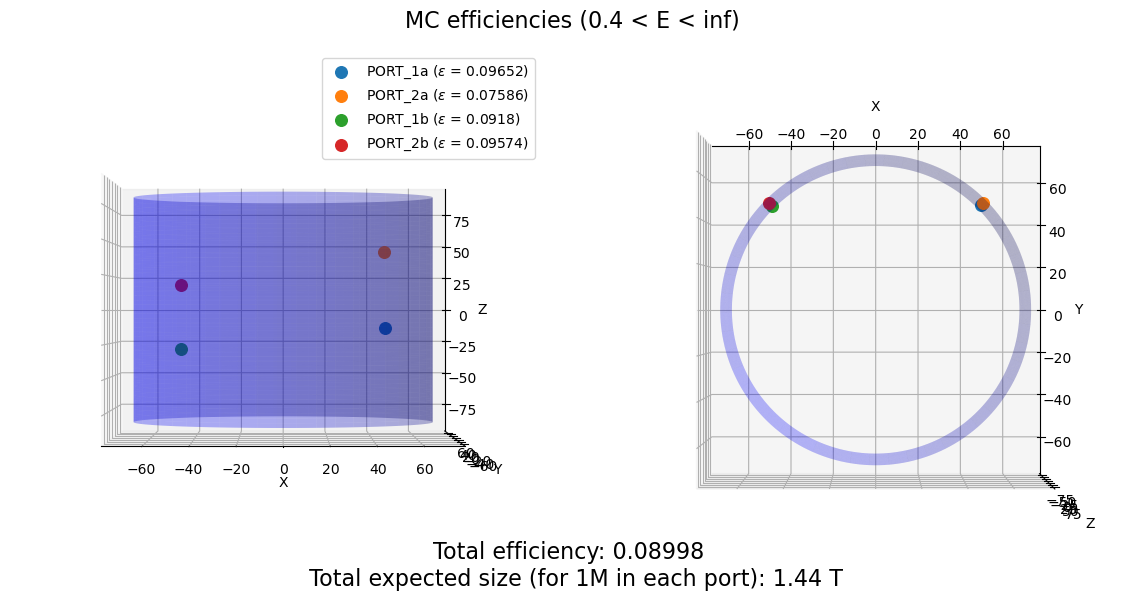

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

fig = plt.figure(figsize = (12, 6))

cyl_surf = cylinder_surface(radius, zmin, zmax, resolution)

def plot_next100_scheme(fig, subplot, cyl_surf, port_info, port_eff, ang = (0, 0)):
    # Create a 3D figure
    
    ax = fig.add_subplot(subplot, projection='3d')

    # Plot the surface of the cylinder
    X, Y, Z = cyl_surf[0], cyl_surf[1], cyl_surf[2]
    ax.plot_surface(X, Y, Z, color='b', alpha= 0.3)

    # Plot the ports of the cylinder
    port_x, port_y, port_z, port_n = port_info
    ax.scatter(port_x[0], port_y[0], port_z[0], marker='o', s=70, label=port_n[0] + ' ($\epsilon$ = {:.4})'.format(port_eff[port_n[0]]))
    ax.scatter(port_x[1], port_y[1], port_z[1], marker='o', s=70, label=port_n[1] + ' ($\epsilon$ = {:.4})'.format(port_eff[port_n[1]]))
    ax.scatter(port_x[2], port_y[2], port_z[2], marker='o', s=70, label=port_n[2] + ' ($\epsilon$ = {:.4})'.format(port_eff[port_n[2]]))
    ax.scatter(port_x[3], port_y[3], port_z[3], marker='o', s=70, label=port_n[3] + ' ($\epsilon$ = {:.4})'.format(port_eff[port_n[3]]))

    
    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=ang[0], azim=ang[1]) 
    return ax

plt.suptitle('MC efficiencies ({} < E < {})'.format(e_range[0], e_range[1]), fontsize=16)
fig.text(0.5, 0.02, 'Total efficiency: {:.4} \n Total expected size (for 1M in each port): {:.3} T'.format(port_eff_208Tl.mean(), exp_size_208Tl.sum() / 1000), ha='center', fontsize=16)
ax = plot_next100_scheme(fig, 121, cyl_surf, port_info, port_eff_208Tl, ang=(0, -90))
ax.legend()
ax = plot_next100_scheme(fig, 122, cyl_surf, port_info, port_eff_208Tl, ang=(90, 270))
plt.tight_layout()

# Show the plot
plt.show()


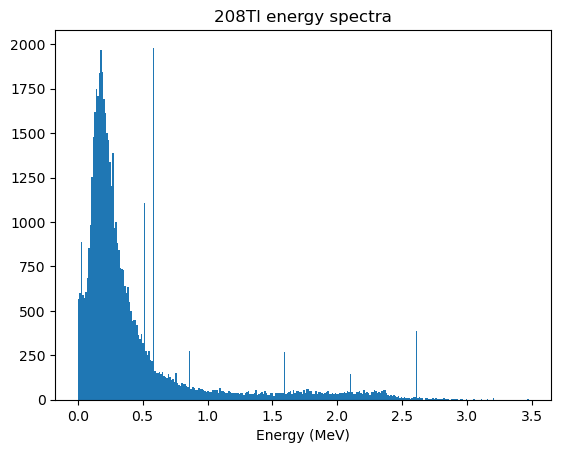

In [15]:
plt.hist(info_df_208Tl.tot_ene, 300)
plt.title('208Tl energy spectra')
plt.xlabel('Energy (MeV)')
plt.show()

# 228Th

Tenemos que checkear de dónde vienen las partículas que dejan trazas en el detector!!

In [16]:
def is_not_mother_in_particles(df):
    is_mother_in_particles = df['mother_id'].isin(df['particle_id'])
    return df[~is_mother_in_particles]

In [17]:
def get_mother_part(part, primary_depo):
    primary_part = pd.DataFrame([])
    for id, part_df in part.groupby('event_id'):
        primary_part = primary_part.append(part_df[part_df['particle_id'].isin(primary_depo[primary_depo.event_id == id].mother_id)][['event_id', 'particle_id', 'particle_name', 'mother_id']])
    return primary_part

def get_primary_particles(f, go_back_in_gammas = False):
    hits_particles = load_dst(f, 'MC', 'hits')[['event_id', 'particle_id']].drop_duplicates()
    part = load_dst(f, 'MC', 'particles')
    hits_part = hits_particles.merge(part[['event_id', 'particle_id', 'particle_name', 'mother_id']], on = ['event_id', 'particle_id'])

    # the first particles in an event that deposit energy
    primary_depo = hits_part.groupby('event_id', group_keys=False).apply(is_not_mother_in_particles).drop_duplicates()

    # the creator particles of the previous ones using their mother_id
    primary_part = get_mother_part(part, primary_depo)

    #try to search for the origin of those that aren't gammas yet
    #create the primary depo df with all gammas although they hadn't deposited any energy, 
    # so we can know where they came from
    if go_back_in_gammas:
        gamma_part = primary_depo[primary_depo.particle_name == 'gamma']
        no_gamma_part = primary_depo[primary_depo.particle_name != 'gamma']

        while len(no_gamma_part) > 0:
            primary_part_ = get_mother_part(part, no_gamma_part)
            gamma_part = gamma_part.append(primary_part_[primary_part_.particle_name == 'gamma'])
            no_gamma_part = primary_part_[primary_part_.particle_name != 'gamma']
        
        primary_part_from_gammas = get_mother_part(part, gamma_part)
    else:
        gamma_part, primary_part_from_gammas = pd.DataFrame(), pd.DataFrame()

    return primary_depo, primary_part, gamma_part, primary_part_from_gammas

In [18]:
# info_df_228Th = pd.DataFrame()
# prim_depo_228Th = pd.DataFrame()
# prim_part_228Th = pd.DataFrame()
# prim_part_from_gammas_228Th = pd.DataFrame()
# for f in sorted(glob.glob(path.format(isotope='228Th', port='*')), key = lambda x: (x.split('/')[-3], int(x.split('_')[-2]))):
#     info_df_228Th = info_df_228Th.append(get_mc_info(f))
#     depo, part, _, part_gammas = get_primary_particles(f, go_back_in_gammas=True)
#     prim_depo_228Th = prim_depo_228Th.append(depo)
#     prim_part_228Th = prim_part_228Th.append(part)
#     prim_part_from_gammas_228Th = prim_part_from_gammas_228Th.append(part_gammas)

In [19]:
save_path_228Th = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calibration/toy_228Th/toy_summary_228Th.h4'
# info_df_228Th.to_hdf(save_path_228Th, key = 'events_info') 
# prim_depo_228Th.to_hdf(save_path_228Th, key = 'prim_depo') 
# prim_part_228Th.to_hdf(save_path_228Th, key = 'prim_part')
# prim_part_from_gammas_228Th.to_hdf(save_path_228Th, key = 'prim_part_from_gamma')
# sim_evs_info.to_hdf(save_path_228Th, key = 'sim_info') 

In [20]:
info_df_228Th = pd.read_hdf(save_path_228Th, key = 'events_info') 
prim_depo_228Th = pd.read_hdf(save_path_228Th, key = 'prim_depo') 
prim_part_228Th = pd.read_hdf(save_path_228Th, key = 'prim_part')
prim_part_from_gammas_228Th = pd.read_hdf(save_path_228Th, key = 'prim_part_from_gamma')
sim_evs_info = pd.read_hdf(save_path_228Th, key = 'sim_info') 

Vale, viendo esto + las primary depositions, creo que no se nos cuelan muchos betas con la simulación total (alguno quizás, chekear)

En principio, la gran mayoría de deposiciones empiezan con un gamma

In [21]:
prim_depo_228Th.particle_name.value_counts()

gamma    37252
e-        1904
e+         401
Xe136      361
Xe134       25
Xe132        5
Name: particle_name, dtype: int64

Los Xe son nuclear recoils supongo, tengo que comprobar :)

Luego ese gamma proviene de varias cosas distintas que no dejaron deposiciones, que en su mayoría eran cosas esperables entiendo. Quizás tenemos que chequear de dónde vienen esas que no son pues ya isótopos (e+ sabemos que vendrán de gammas, entonces pues de qué gammas vienen y esas cosas... un poco hasta llegar al isotopo que toca, en lugar de a una particula que anda por ahí)

In [22]:
prim_part_228Th.particle_name.value_counts()

Bi212[238.632]     8499
Pb208[3197.711]    8011
Pb208[2614.522]    7475
Pb208[3708.451]    2182
gamma              2002
Po212[727.330]     1744
Pb208[3475.078]    1695
e+                 1157
e-                 1143
Bi212[415.272]      799
Rn220[240.986]      785
Po212[1620.738]     483
Po212[1512.700]     352
Pb208[3961.162]     272
Po212[1805.960]     164
Tl208[328.040]      116
Tl208[492.840]       72
Bi212[115.183]       58
Ra224[215.985]       55
Po212[1679.450]      51
Pb208[3919.966]      30
Pb208[4180.414]      24
Po216[549.760]       20
Ra224[250.783]       19
Ra224[84.373]        18
Pb208[4296.560]      11
Pb208[4125.347]      11
Tl208[473.400]       10
Pb208[4480.746]       6
Po212[1800.900]       4
Ra224[290.360]        3
Tl208[620.400]        2
Rn220[533.680]        2
Rn220[645.440]        1
Rn220[663.030]        1
Pb208[3995.438]       1
Pb208[4358.670]       1
Pb208[3946.578]       1
Name: particle_name, dtype: int64

In [23]:
prim_part_from_gammas_228Th.particle_name.value_counts()

Bi212[238.632]     8809
Pb208[2614.522]    8279
Pb208[3197.711]    8211
Pb208[3708.451]    2235
Po212[727.330]     1799
Pb208[3475.078]    1754
gamma              1273
e+                 1191
e-                 1169
Bi212[415.272]      819
Rn220[240.986]      818
Po212[1620.738]     512
Po212[1512.700]     361
Pb208[3961.162]     281
Po212[1805.960]     172
Tl208[328.040]      121
Tl208[492.840]       75
Bi212[115.183]       63
Ra224[215.985]       56
Po212[1679.450]      56
Pb208[3919.966]      30
Pb208[4180.414]      26
Po216[549.760]       20
Ra224[84.373]        20
Ra224[250.783]       19
Pb208[4125.347]      12
Pb208[4296.560]      11
Tl208[473.400]       10
Pb208[4480.746]       6
Po212[1800.900]       4
Ra224[290.360]        3
Tl208[620.400]        2
Rn220[533.680]        2
Pb208[4358.670]       2
Rn220[645.440]        1
Rn220[663.030]        1
Pb208[3995.438]       1
Pb208[3946.578]       1
Name: particle_name, dtype: int64

In [122]:
#_, _ = print_effs_and_sim(info_df_228Th, '228Th', size_df)

Que tenga menos eficiencia (teniendo en cuenta que la eficiencia la calculamos como los eventos obtenidos / simulados) no sé muy bien qué quiere decir... consultar esto porque...

Podría ser porque al final de la cadena, hay 2 caminos:

* 212Pb -- beta --> 212Bi -- beta  --> 212Po -- alpha --> 208Pb
* 212Pb -- beta --> 212Bi -- alpha --> 208Tl -- beta  --> 208Pb

Entonces, al simular sólo 208Tl aprovechamos todo, al simular 228Th hay una parte que me va por el camino del Polonio en lugar del del Talio (de hecho vemos contribuciones).

In [121]:
port_eff_228Th, exp_size_228Th = print_effs_and_sim(info_df_228Th, '228Th', size_df, e_threshold=(0.4, np.inf))

MC efficiencies (0.4 < E < inf)
Each port:
port
PORT_1a    0.04182
PORT_1b    0.03910
PORT_2a    0.03322
PORT_2b    0.04012
dtype: float64

Total efficiency
0.038565

In each port we will need to simulate (to have at least 1M events):
port
PORT_1a    2.391200e+07
PORT_1b    2.557545e+07
PORT_2a    3.010235e+07
PORT_2b    2.492522e+07
dtype: float64

Which we can set up to:
30200000.0  events per port
1510.0  tasks/files per port if we simulate  20000.0  events per file
With the current eff, these files will have around  771.3000000000001  events per file

For having 1M, we expect that the production will occupy:
port
PORT_1a    1004.304161
PORT_1b    1074.168798
PORT_2a    1143.889223
PORT_2b    1046.859422
dtype: float64
In total: 4269.221603736848 G


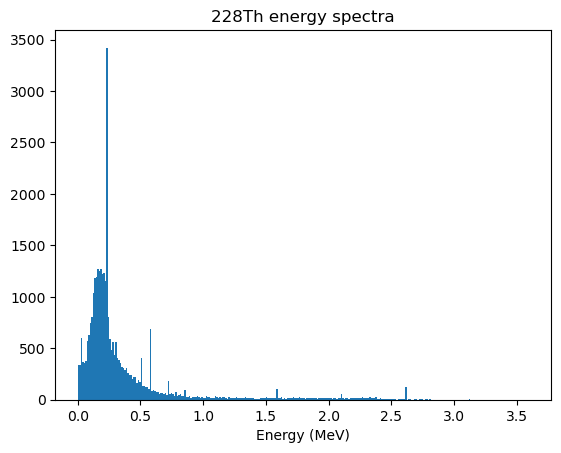

In [26]:
plt.hist(info_df_228Th.tot_ene, 300)
plt.title('228Th energy spectra')
plt.xlabel('Energy (MeV)')
plt.show()

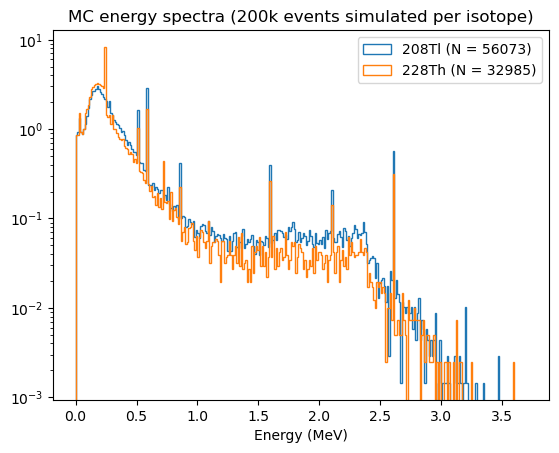

In [37]:
nbins = 300
xrange = (0, 3.7)
plt.hist(info_df_208Tl.tot_ene, nbins, range = xrange, density = True, histtype='step', label = '208Tl (N = {})'.format(len(info_df_208Tl)))
plt.hist(info_df_228Th.tot_ene, nbins, range = xrange, density = True, histtype='step', label = '228Th (N = {})'.format(len(info_df_228Th)))
plt.title('MC energy spectra (200k events simulated per isotope)')
plt.legend()
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.show()

Pienso que todo en orden viendo los espectros no??

In [30]:
prim_part_228Th[prim_part_228Th.particle_name.str.contains('Ra')].particle_name.unique()

array(['Ra224[215.985]', 'Ra224[84.373]', 'Ra224[250.783]',
       'Ra224[290.360]'], dtype=object)

Encontramos los 4 estados excitados; todos decaen a 84 antes de decaer al estado fundamental (salvo 215, que puede decaer directamente a 0 o no)

In [31]:
prim_part_228Th[prim_part_228Th.particle_name.str.contains('Rn')].particle_name.unique()

array(['Rn220[240.986]', 'Rn220[533.680]', 'Rn220[645.440]',
       'Rn220[663.030]'], dtype=object)

Para el Rn veo que hay los 4 estados excitados, pero en el IAEA sólo aparece el gamma de 240 :/ Si fuera al revés lo entendería, porque simplemente sería que el gamma pues no interactuó con el detector, pero aqui parece que me falta info en el IAEA o estoy entendiendo mal

In [32]:
prim_part_228Th[prim_part_228Th.particle_name.str.contains('Po216')].particle_name.unique()

array(['Po216[549.760]'], dtype=object)

Efectivamente, para el Po encontramos su estado excitado :)

In [33]:
prim_part_228Th[prim_part_228Th.particle_name.str.contains('Pb212')].particle_name.unique()

array([], dtype=object)

Solo habría un gamma de 800, pero parece ser que no lo encontré o lo que sea, no pasa nada

In [34]:
prim_part_228Th[prim_part_228Th.particle_name.str.contains('Bi')].particle_name.unique()

array(['Bi212[238.632]', 'Bi212[415.272]', 'Bi212[115.183]'], dtype=object)

238 decae directamente, 415 decae a 115 con un gamma de 300 y luego el gamma de 115

El gamma de 238 se ve un gran pico

Aquí nos dividimos, puidendo ir a 212Po, 208Pb (64%); o 208Tl, 208Pb (36%)

In [35]:
prim_part_228Th[prim_part_228Th.particle_name.str.contains('Po212')].particle_name.unique()

array(['Po212[1620.738]', 'Po212[727.330]', 'Po212[1512.700]',
       'Po212[1805.960]', 'Po212[1679.450]', 'Po212[1800.900]'],
      dtype=object)

Muchos gammas por ahi, lo único que creo que son tantos que no se llegan a ver  más que el de 727 (si ampliamos sí que se van viendo!!, como 1620, 785, 1708...)

In [36]:
prim_part_228Th[prim_part_228Th.particle_name.str.contains('Pb208')].particle_name.unique()

array(['Pb208[2614.522]', 'Pb208[3197.711]', 'Pb208[3475.078]',
       'Pb208[3708.451]', 'Pb208[3961.162]', 'Pb208[4296.560]',
       'Pb208[4125.347]', 'Pb208[4180.414]', 'Pb208[3919.966]',
       'Pb208[4480.746]', 'Pb208[3995.438]', 'Pb208[4358.670]',
       'Pb208[3946.578]'], dtype=object)